In [144]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

In [71]:
def plot_image(image, boxes, labels, scores):
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(10,10))
    
    for box,label, score in zip(boxes, labels, scores):
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 1)
        label = categories[label]['name'].upper() + " " + str(score)
        print(label)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 0.5,
                    color = (255, 0, 0),
                    thickness = 1,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [109]:
import pickle
from ensemble_boxes import *

with open('./test.pkl', 'rb') as f:
    data = pickle.load(f)

In [110]:
test_df = pd.read_csv('test.csv')

test_healthy = pd.read_csv('test_healthy.csv')
# l = list(test_healthy[test_healthy.label < 0.01].image_id)

# healthy = list(map(lambda x: x[:-10], l))
test_healthy['image_id'] = test_healthy['image_id'].apply(lambda x: x[:-10])
test_healthy = test_healthy.set_index('image_id')

In [126]:
submission_vals = []

score_thr = 0.45
iou_thr = 0.5

low_thr = 0.0005
high_thr = 0.5

for _id, preds in zip(range(len(test_df)), data):
    
    r = test_df.iloc[_id]
    
    image_id = r['image_id']
    
    health_score = test_healthy.loc[image_id]['label']
    
    width = r['width']
    height = r['height']
#     width = 1024
#     height = 1024
    
    boxes = []
    scores = []
    labels = []
    
    for i, pred in enumerate(preds):
        if len(pred):
            for p in pred:
                
                score = p[4].astype(float)
                
                if score > score_thr:

                    box = p[:4] / 1024

                    boxes.append(box)
                    scores.append(score)
                    labels.append(i)
                    
    if len(boxes) == 0 or health_score < low_thr:
        pred_str = '14 1 0 0 1 1'
        submission_vals.append([image_id, pred_str])
        continue 
    
    boxes, scores, labels = nms([boxes], [scores], [labels], iou_thr=iou_thr)
    
    boxes[:, 0] = boxes[:, 0]*width
    boxes[:, 2] = boxes[:, 2]*width
    boxes[:, 1] = boxes[:, 1]*height
    boxes[:, 3] = boxes[:, 3]*height
    
    scaled_boxes = boxes.astype(int)
    labels = labels.astype(int)
    _id_preds = []

    for i in range(len(scaled_boxes)):
        _id_preds.append(str(labels[i]))
        _id_preds.append(str(scores[i].round(2)))
        _id_preds.append(str(scaled_boxes[i][0]))
        _id_preds.append(str(scaled_boxes[i][1]))
        _id_preds.append(str(scaled_boxes[i][2]))
        _id_preds.append(str(scaled_boxes[i][3]))

    pred_str = " ".join(_id_preds)
        
    if high_thr > health_score > low_thr:
        pred_str += f' 14 {health_score.round(2)} 0 0 1 1'
    submission_vals.append([image_id, pred_str])

df = pd.DataFrame(submission_vals, columns = ['image_id','PredictionString'])

In [127]:
len(df[df['PredictionString'] == '14 1 0 0 1 1'])

1995

In [133]:
df.to_csv("submission.csv",index=False)

In [142]:
# sub = pd.read_csv('submission_prev_best.csv')
sub = pd.read_csv('submission.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6da36354fc904b63bc03eb3884e0c35c
AORTIC ENLARGEMENT 0.96
LUNG OPACITY 0.52
PLEURAL THICKENING 0.56
PULMONARY FIBROSIS 0.84
PULMONARY FIBROSIS 0.8
PULMONARY FIBROSIS 0.48


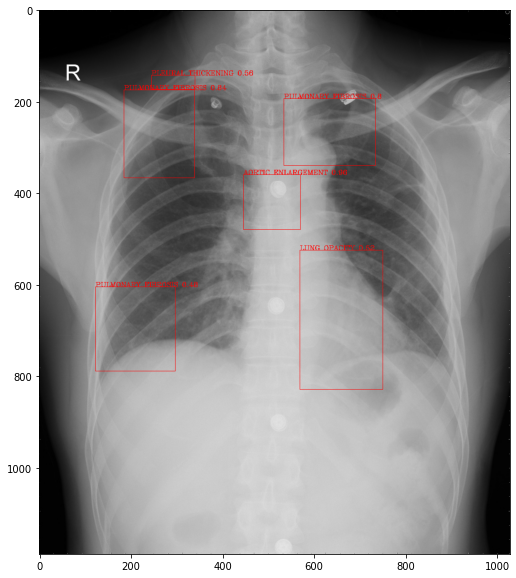

In [143]:
row = sub.iloc[5 - 1]
pred_string = row['PredictionString']
image_id = row['image_id']
print(image_id)
img_path = 'test_2x/test/' + image_id + '.jpg'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255
image = image.astype('float32')

# boxes = np.array(boxes)
# boxes
pred = np.array(list(map(lambda x: float(x), pred_string.split(' '))))
pred = pred.reshape(-1,6)

boxes = pred[:, 2:].astype(int) // 2
scores = pred[:,1].astype(float)
labels = pred[:,0].astype(int)

plot_image(image, boxes, labels, scores)
# boxes, labels